# Results - smMIPs Sequencing and Data Analysis

## Tools

In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='white')
sns.set_context("talk")
import matplotlib.pyplot as plt
import glob
import os
import requests

In [2]:
from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')
li = LiftOver('hg38', 'hg19')

## Pull in Input Files

In [3]:
samples = pd.read_csv('../data/validation_samples/sample_dataframe.txt', sep='\t')

In [4]:
samples_QC = pd.read_csv('../data/validation_samples/sequencing_quality_check.txt', sep='\t')

In [5]:
overlap_with_smmips = pd.read_csv('../output/variant_overlap.tsv', sep='\t')

In [6]:
WEX_variants = pd.read_csv('../data/original_sequencing/VCF_exome.txt', sep='\t')

## Initial Quality Check

In [7]:
print('Mean: ', samples_QC['total tags weighted'].mean())
mean = samples_QC['total tags weighted'].mean()
print('Standard Deviation: ', samples_QC['total tags weighted'].std())
std = samples_QC['total tags weighted'].std()

Mean:  5369817.166666667
Standard Deviation:  3334506.223398502


In [8]:
ineligible_samples = []
for i,row in samples_QC.iterrows():
    if row['total tags weighted'] < mean - 1*std or row['total unique mips captured'] < 600000:
        print(row['count'] + '_' +  row['Type'])
        if row['Type'] == 'tumor':
            ineligible_samples.append(row['count'] + '_' +  row['Type'])

HL_1_normal
HL_2_tumor
OSCC_2_tumor
OSCC_3_tumor
OSCC_4_normal
SCLC_1_normal
SCLC_2_normal
SCLC_3_normal
SCLC_6_normal
SCLC_7_normal


In [9]:
print('Number of elgible Samples: ', len(samples_QC) - len(ineligible_samples))

Number of elgible Samples:  33


In [10]:
# If tumor is ineligible, eliminate variants for subsequent analysis
overlap_with_smmips['Passed QC'] = ''
for i,row in overlap_with_smmips.iterrows():
    if row['sample'] + '_' +  'tumor' in ineligible_samples:
        overlap_with_smmips.loc[[i], 'Passed QC'] = 'no'
    else:
        overlap_with_smmips.loc[[i], 'Passed QC'] = 'yes'

In [11]:
print('Number of Eligible Individuals: ', len(overlap_with_smmips[overlap_with_smmips['Passed QC'] == 'yes'][['sample']].drop_duplicates()))

Number of Eligible Individuals:  19


In [12]:
print('Number of Eligible Variants: ',overlap_with_smmips[overlap_with_smmips['Passed QC'] == 'yes'].groupby('sample').size().sum())

Number of Eligible Variants:  65


## Accuracy profile of smMIPs CIViC panel when compared to WEX

 ### Pull in VCF Files

In [13]:
smmips_variants = pd.DataFrame()

In [14]:
smmips_variants = pd.DataFrame()
for item in glob.glob('../data/smmips_sequencing/*T*.snp.vcf'):
    name = item.split('/')[3].split('_')[0] + '_' + item.split('/')[3].split('_')[1]
    current = pd.read_csv(item, sep='\t', comment='#', header=None).filter(items=[0,1,1,3,4,9])
    current['sample'] = name
    smmips_variants = smmips_variants.append(current)

In [15]:
for item in glob.glob('../data/smmips_sequencing/*T*.indel.vcf'):
    name = item.split('/')[3].split('_')[0] + '_' + item.split('/')[3].split('_')[1]
    current = pd.read_csv(item, sep='\t', comment='#', header=None).filter(items=[0,1,1,3,4,9])
    current['sample'] = name
    current[1] = current[1] + 1
    current[3] = current[3].str[1:].replace('', '-')
    current[4] = current[4].str[1:].replace('', '-')
    smmips_variants = smmips_variants.append(current)

In [16]:
smmips_variants.columns = ['chrom', 'start', 'stop', 'reference', 'variant', 'CIViC Panel VAF', 'sample']
smmips_variants = smmips_variants.reset_index()

In [17]:
for i,row in smmips_variants.iterrows():
    VAF = float(str(row['CIViC Panel VAF']).split(':')[-1])*100
    smmips_variants.loc[[i], 'CIViC Panel VAF'] = VAF

In [18]:
overlap_with_smmips = overlap_with_smmips.merge(smmips_variants, on=['chrom', 'start','sample'], how='left')

In [19]:
overlap_with_smmips['CIViC Panel VAF'] = overlap_with_smmips['CIViC Panel VAF'].replace(np.nan, 0)
overlap_with_smmips['CIViC Panel VAF'] = overlap_with_smmips['CIViC Panel VAF'].astype('float')

In [20]:
overlap_with_smmips = overlap_with_smmips.drop(['reference_y', 'stop_x', 'stop_y', 'variant_y', 'index'], axis=1)

In [21]:
print('Total eligible variants: ', len(overlap_with_smmips[overlap_with_smmips['Passed QC'] == 'yes']))
print('Total eligible overlap with smMIPs: ', len(overlap_with_smmips[(overlap_with_smmips['CIViC Panel VAF'] > 0) & (overlap_with_smmips['Passed QC'] == 'yes')]))

Total eligible variants:  65
Total eligible overlap with smMIPs:  61


In [22]:
overlap_with_smmips = overlap_with_smmips.drop(['Unnamed: 0'], axis=1)

In [23]:
overlap_with_smmips.to_csv('/Users/ebarnell/Desktop/variant_overlap.tsv', sep='\t', index=False)

In [24]:
overlap_with_smmips.to_csv('../output/variant_overlap.tsv', sep='\t', index=False)

### Build Waterfall Dataframe 

In [25]:
samples_waterfall = overlap_with_smmips[overlap_with_smmips['Passed QC'] == 'yes']

In [26]:
# Make dataframe for WaterFall plot (Figure 1)
samples_waterfall = samples_waterfall.filter(items=['sample', 'gene_name', 'amino_acid', 'VAF', 'CIViC Panel VAF'])
samples_waterfall['Validated'] = (samples_waterfall['CIViC Panel VAF'] > 0).astype('int')

samples_waterfall.to_csv('../data/smMIPs_waterfall/waterfall_dataframe.tsv', sep='\t')

## Variant allele frequency correlation between  smMIPs CIViC panel and exome/genome sequencing

In [27]:
palette_color ={"yes":"#182C61","no":"#D9B08C",True:"#182C61", False:"#D9B08C", 
                'OSCC':'#2F4454', 'SCLC':'#2E151B', 'CRC':'#DA7B93', 'AML':'#376E6F', 'HL':'#1C3334',
               '100ng':'#2F4454', '250ng':'#2E151B', '500ng':'#DA7B93',
               '0X':'#D7E2E2','0-100X':'#87A8A9','100-250X':'#376E6F','250-500X':'#1C3738','500-1,000X':'#0E1C1C', '>1,000X':'#000000'}

In [28]:
print('Variants obtained from samples that failed CIViC smMIPs capture panel:', len(overlap_with_smmips[overlap_with_smmips['Passed QC'] == 'no']))

Variants obtained from samples that failed CIViC smMIPs capture panel: 19


In [29]:
sample_info = pd.read_csv('../data/validation_samples/sample_dataframe.txt', sep='\t')

In [30]:
correlation = overlap_with_smmips[(overlap_with_smmips['CIViC Panel VAF'] != 0) & (overlap_with_smmips['VAF'] != 0)]

In [31]:
print('Variants in correlation:', len(correlation))
pd.DataFrame.corr(correlation.filter(items=['CIViC Panel VAF', 'VAF']),method='pearson')

Variants in correlation: 61


,CIViC Panel VAF,VAF
CIViC Panel VAF,1.0000,0.8851
VAF,0.8851,1.0000


In [32]:
overlap_with_smmips_data = overlap_with_smmips.merge(sample_info, right_on='Sample', left_on='sample')

In [33]:
overlap_with_smmips_data['Status'] = overlap_with_smmips_data['CIViC Panel VAF'] > 0

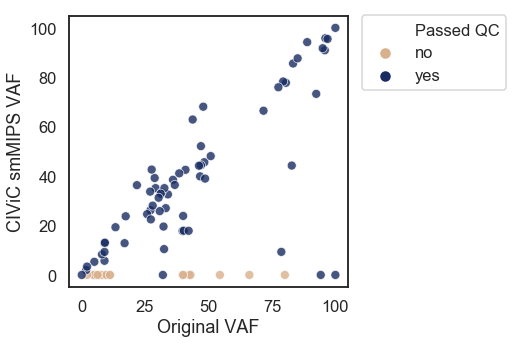

In [34]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data, alpha=0.8, hue='Passed QC', palette=palette_color)
plt.xlabel('Original VAF')
plt.ylabel('CIViC smMIPS VAF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_PassedQC.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

In [35]:
overlap_with_smmips_data_PASSED = overlap_with_smmips_data[overlap_with_smmips_data['Passed QC'] == 'yes']

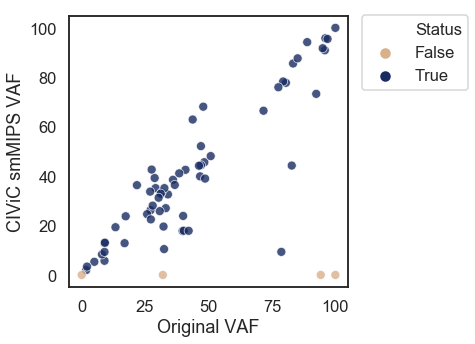

In [36]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data_PASSED, alpha=0.8, hue='Status', palette=palette_color)
plt.xlabel('Original VAF')
plt.ylabel('CIViC smMIPS VAF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_Status.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

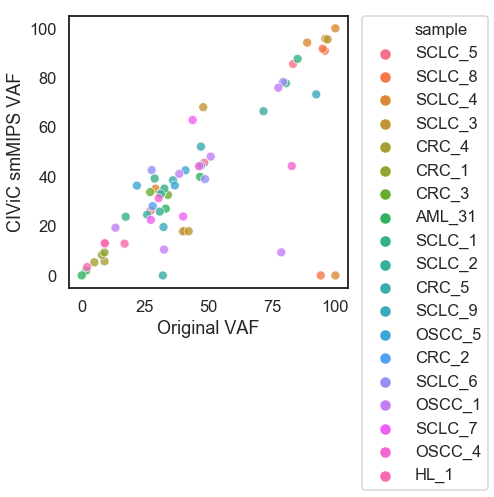

In [37]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data_PASSED, alpha=0.8, hue='sample')
plt.xlabel('Original VAF')
plt.ylabel('CIViC smMIPS VAF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_Sample.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

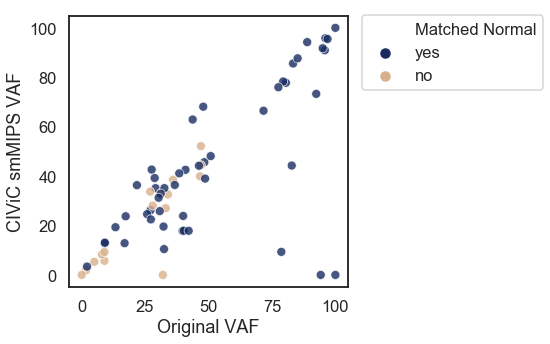

In [38]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data_PASSED, alpha=0.8, hue='Matched Normal', palette=palette_color)
plt.xlabel('Original VAF')
plt.ylabel('CIViC smMIPS VAF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_MatchedNormal.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

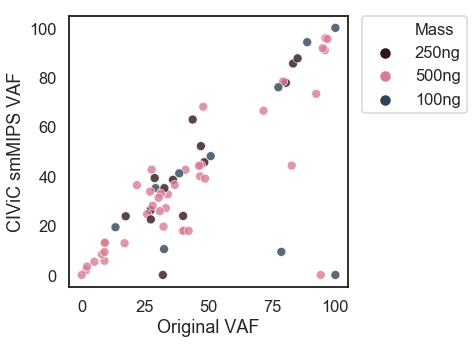

In [39]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data_PASSED, alpha=0.8, hue='Mass', palette=palette_color)
plt.xlabel('Original VAF')
plt.ylabel('CIViC smMIPS VAF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_Mass.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

In [40]:
def avg_coverage (row):
    if row['Coverage'] == 0 :
        return '0X'
    if row['Coverage'] > 0 and row['Coverage'] < 100:
        return '0-100X'
    if row['Coverage'] >= 100 and row['Coverage'] < 250:
        return '100-250X'
    if row['Coverage'] >= 250 and row['Coverage'] < 500:
        return '250-500X'
    if row['Coverage'] >= 500 and row['Coverage'] < 1000:
        return '500-1,000X'
    if row['Coverage'] >= 1000:
        return '>1,000X'

In [41]:
overlap_with_smmips_data_PASSED['Average Coverage'] = overlap_with_smmips_data_PASSED.apply(lambda row: avg_coverage (row),axis=1)

/Users/ebarnell/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


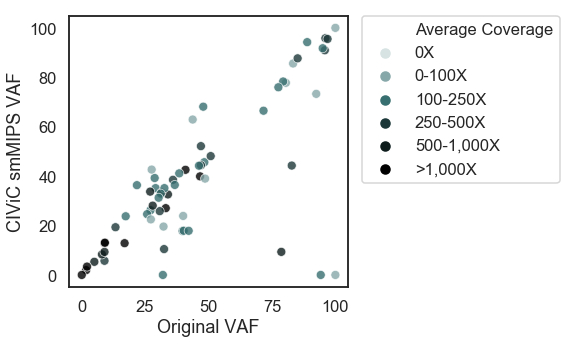

In [42]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data_PASSED, alpha=0.8, palette=palette_color, hue='Average Coverage', 
                hue_order=['0X','0-100X','100-250X','250-500X','500-1,000X', '>1,000X'])
plt.xlabel('Original VAF')
plt.ylabel('CIViC smMIPS VAF')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_Coverage.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

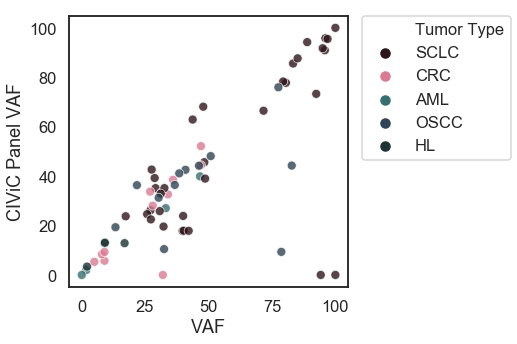

In [43]:
plt.figure(figsize=(5,5))
sns.scatterplot(x="VAF", y="CIViC Panel VAF", data=overlap_with_smmips_data_PASSED, alpha=0.8, hue='Tumor Type', palette=palette_color)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('../data/Figures/VAF_correlation_TumorType.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()